In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.cluster import AgglomerativeClustering
from sklearn import preprocessing

In [2]:
# This function is used to scale indicated variables
# down to a range of [0, 1], using Min-Max Scaling
def scale_cols(x, idxs):
    othercols = [list(x)[y] for y in set(range(0, len(list(x)))) - set(idxs)]
    scalecols = [list(x)[y] for y in idxs]
    scalable = x[scalecols]
    scaled = pd.DataFrame(data=preprocessing.MinMaxScaler().fit_transform(scalable),
                            columns=scalecols)
    all = pd.concat([x[othercols], scaled], axis=1)[list(x)]
    return(all)

# This function calculates the accuracy of a classification
# attempt by measuring the number of correct pairwise relationships
# between individuals. 
def cluster_accuracy(true, pred):
    speclabels = pd.DataFrame({'idx': list(range(0, len(true))), 'species': true, 'by': 1})
    specpairs = pd.merge(speclabels, speclabels, on='by').query('idx_x != idx_y')
    specpairs['match'] = specpairs.species_x == specpairs.species_y 

    predlabels = pd.DataFrame({'idx': list(range(0, len(pred))), 'species': pred, 'by': 1})
    predpairs = pd.merge(predlabels, predlabels, on='by').query('idx_x != idx_y')
    predpairs['match'] = predpairs.species_x == predpairs.species_y

    success = sum(specpairs.match == predpairs.match)
    total = predpairs.shape[0]
    accuracy = success/total*100
    return(accuracy)

In [3]:
fish = pd.read_csv("data/fishcatch.csv").drop(['Unnamed: 0', 'obs', 'sex'], axis=1)

In [4]:
# Basically the raw measurements, only scaled
rawfish = scale_cols(fish.drop('species', axis=1), range(0,6))

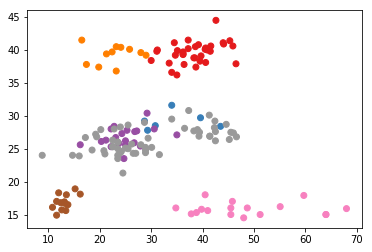

In [5]:
plt.scatter(x = fish.length3, y = fish.height, c = fish.species, cmap=cm.Set1)
plt.savefig('figures/true.png', bbox_inches='tight')

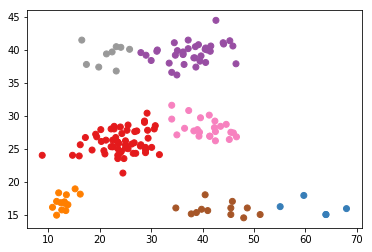

In [6]:
X = rawfish.filter(items=['length3', 'height'])
simpleagg = AgglomerativeClustering(linkage='average', n_clusters=7).fit(X)
plt.scatter(x = fish.length3, y = fish.height, c = simpleagg.labels_, cmap=cm.Set1)
plt.savefig('figures/simple_pred.png', bbox_inches='tight')

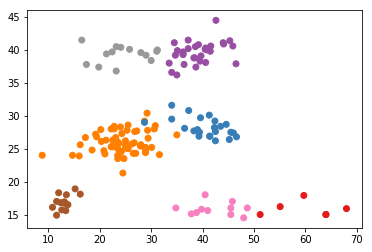

In [7]:
X = rawfish
rawagg = AgglomerativeClustering(linkage='average', n_clusters=7).fit(X)
plt.scatter(x = fish.length3, y = fish.height, c = rawagg.labels_, cmap=cm.Set1)
plt.savefig('figures/raw_pred.png', bbox_inches='tight')

In [8]:
# More strategic feature encoding
# Convert all measurements to ratios of the full length
fishratio = pd.DataFrame({  'length'    : fish.length3,
                            'bodylenR'  : fish.length1/fish.length3,
                            'taillenR'  : (fish.length3 - fish.length1)/fish.length3,
                            'maintailR' : (fish.length2 - fish.length1)/fish.length3,
                            'tailtrailR': (fish.length3 - fish.length2)/fish.length3,
                            'heightR'   : fish.height/fish.length3,
                            'widthR'    : fish.width/fish.length3,
                            'weightR'   : fish.weight/fish.length3 })
fishratio = fishratio[['length', 'bodylenR', 'taillenR', 'maintailR', 'tailtrailR', 'heightR', 'widthR', 'weightR']]
ratiofish = scale_cols(fishratio, range(0,8))

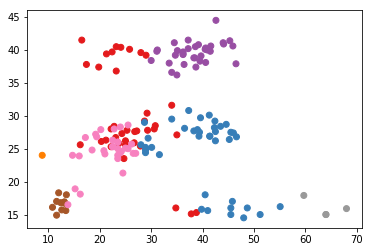

In [9]:
X = ratiofish
ratioagg = AgglomerativeClustering(linkage='average', n_clusters=7).fit(X)
plt.scatter(x = fish.length3, y = fish.height, c = ratioagg.labels_, cmap=cm.Set1)
plt.savefig('figures/ratio_pred.png', bbox_inches='tight')

In [10]:
# bothfish includes scaled raw measurements and scaled ratios
bothfish = pd.concat([rawfish, ratiofish], axis=1)
bothfish = bothfish[['length', 'weight', 'height', 'width',          # Core measurements
                     'length1', 'length2',                           # More specific lengths
                     'bodylenR', 'taillenR', 'maintailR',            # Measurement ratios
                     'tailtrailR', 'heightR', 'widthR', 'weightR']]

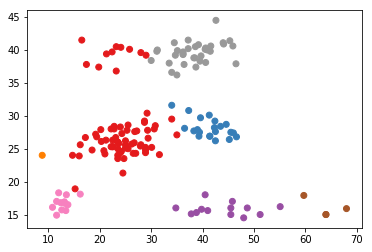

In [11]:
X = bothfish
bothagg = AgglomerativeClustering(linkage='average', n_clusters=7).fit(X)
plt.scatter(x = fish.length3, y = fish.height, c = bothagg.labels_, cmap=cm.Set1)
plt.savefig('figures/both_pred.png', bbox_inches='tight')

In [12]:
print('Simple data: {}\nRaw data: {}\nRatio data: {}\nBoth data: {}'.format(
    cluster_accuracy(fish.species, simpleagg.labels_),
    cluster_accuracy(fish.species, rawagg.labels_), 
    cluster_accuracy(fish.species, ratioagg.labels_),
    cluster_accuracy(fish.species, bothagg.labels_)))

Simple data: 85.26969281625412
Raw data: 84.93106506490365
Ratio data: 85.39869386438765
Both data: 79.91614931871321
